<font size="+3">Time-series Generative Adversarial Network (TimeGAN)</font>

# Imports & Settings

Adapted from the excellent paper by Jinsung Yoon, Daniel Jarrett, and Mihaela van der Schaar:  
[Time-series Generative Adversarial Networks](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks),  
Neural Information Processing Systems (NeurIPS), 2019.

- Last updated Date: April 24th 2020
- [Original code](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/timegan/) author: Jinsung Yoon (jsyoon0823@gmail.com)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
conda install conda-forge::tables

Channels:
 - defaults
 - conda-forge
 - apple
Platform: osx-arm64
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - conda-forge::tables

Current channels:

  - defaults
  - https://conda.anaconda.org/conda-forge
  - https://conda.anaconda.org/conda-forge
  - https://conda.anaconda.org/apple/osx-arm64

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


In [18]:
conda install tables

Channels:
 - defaults
 - conda-forge
 - apple
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Users/philippebeliveau/miniforge3/envs/tensorflow

  added / updated specs:
    - tables


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blosc-1.21.3               |       h313beb8_0          41 KB
    c-blosc2-2.12.0            |       h7df6c2f_0         266 KB
    lzo-2.10                   |       h1a28f6b_2         129 KB
    numexpr-2.8.7              |   py39hecc3335_0         124 KB
    py-cpuinfo-9.0.0           |   py39hca03da5_0          46 KB
    tables-3.9.2               |   py39h2f855a9_0         1.4 MB
    zlib-ng-2.0.7              |       h80987f9_0          92 KB
    ------------------------------------------------------------
                                           Total:         2.0 MB

The following NEW packages will be INSTAL

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [3]:
sns.set_style('white')

# Data import

In [4]:
DATA_STORE = Path('/Users/philippebeliveau/Desktop/Notebook/GAN/Dataset')

In [77]:
DATA_STORE = Path('/Users/philippebeliveau/Desktop/Notebook/GAN/Dataset.h5')

df = (pd.read_csv('/Users/philippebeliveau/Desktop/Notebook/GAN/Dataset/wiki_prices.csv',
                 parse_dates=['date'],
                 index_col=['date', 'ticker'],
                 infer_datetime_format=True)
     .sort_index())

print(df.info(null_counts=True))
with pd.HDFStore(DATA_STORE) as store:
    store.put('quandl/wiki/prices', df)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15389314 entries, (Timestamp('1962-01-02 00:00:00'), 'ARNC') to (Timestamp('2018-03-27 00:00:00'), 'ZUMZ')
Data columns (total 12 columns):
 #   Column       Non-Null Count     Dtype  
---  ------       --------------     -----  
 0   open         15388776 non-null  float64
 1   high         15389259 non-null  float64
 2   low          15389259 non-null  float64
 3   close        15389313 non-null  float64
 4   volume       15389314 non-null  float64
 5   ex-dividend  15389314 non-null  float64
 6   split_ratio  15389313 non-null  float64
 7   adj_open     15388776 non-null  float64
 8   adj_high     15389259 non-null  float64
 9   adj_low      15389259 non-null  float64
 10  adj_close    15389313 non-null  float64
 11  adj_volume   15389314 non-null  float64
dtypes: float64(12)
memory usage: 1.4+ GB
None


# Experiment Path

In [5]:
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

In [6]:
experiment = 0

In [7]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [8]:
hdf_store = results_path / 'TimeSeriesGAN.h5'

# Prepare Data

## Parameters

In [9]:
seq_len = 24
n_seq = 6
batch_size = 128

In [10]:
tickers = ['BA', 'CAT', 'DIS', 'GE', 'IBM', 'KO']

In [11]:
def select_data():
    df = (pd.read_hdf('/Users/philippebeliveau/Desktop/Notebook/GAN/Dataset.h5', 'quandl/wiki/prices')
          .adj_close
          .unstack('ticker')
          .loc['2000':, tickers]
          .dropna())
    df.to_hdf(hdf_store, 'data/real')

In [12]:
select_data()

In [187]:
df.head()

ticker,BA,CAT,DIS,GE,IBM,KO
date,,,,,,
2000-01-03,27.180308,14.984244,23.839401,29.005613,85.155442,17.779754
2000-01-04,27.139731,14.790123,25.235618,27.845388,82.263093,17.839810
2000-01-05,29.040120,15.347834,26.129196,27.797045,85.155442,18.035783
2000-01-06,29.121276,15.908626,25.235618,28.168317,83.687245,18.016818
2000-01-07,29.966645,16.426281,24.836699,29.258928,83.320195,19.202135


## Plot Series

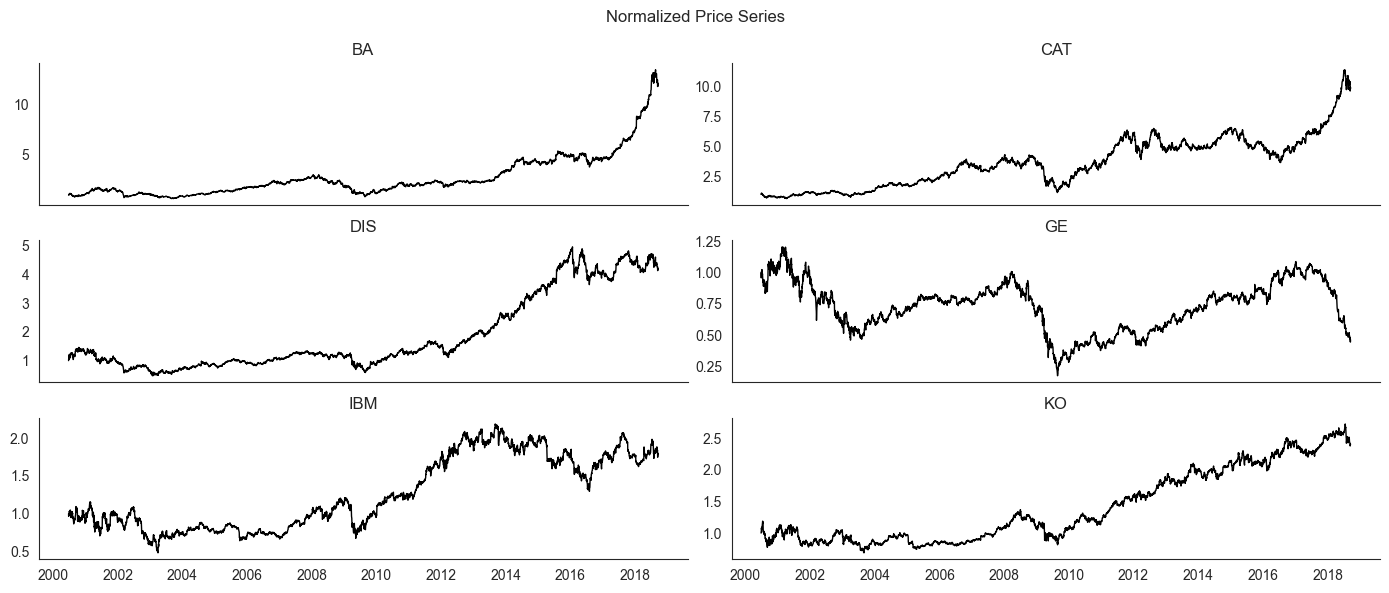

In [13]:
df = pd.read_hdf(hdf_store, 'data/real')
axes = df.div(df.iloc[0]).plot(subplots=True,
                               figsize=(14, 6),
                               layout=(3, 2),
                               title=tickers,
                               legend=False,
                               rot=0,
                               lw=1, 
                               color='k')
for ax in axes.flatten():
    ax.set_xlabel('')

plt.suptitle('Normalized Price Series')
plt.gcf().tight_layout()
sns.despine();

In [15]:
len(df['BA'])

4586

## Correlation

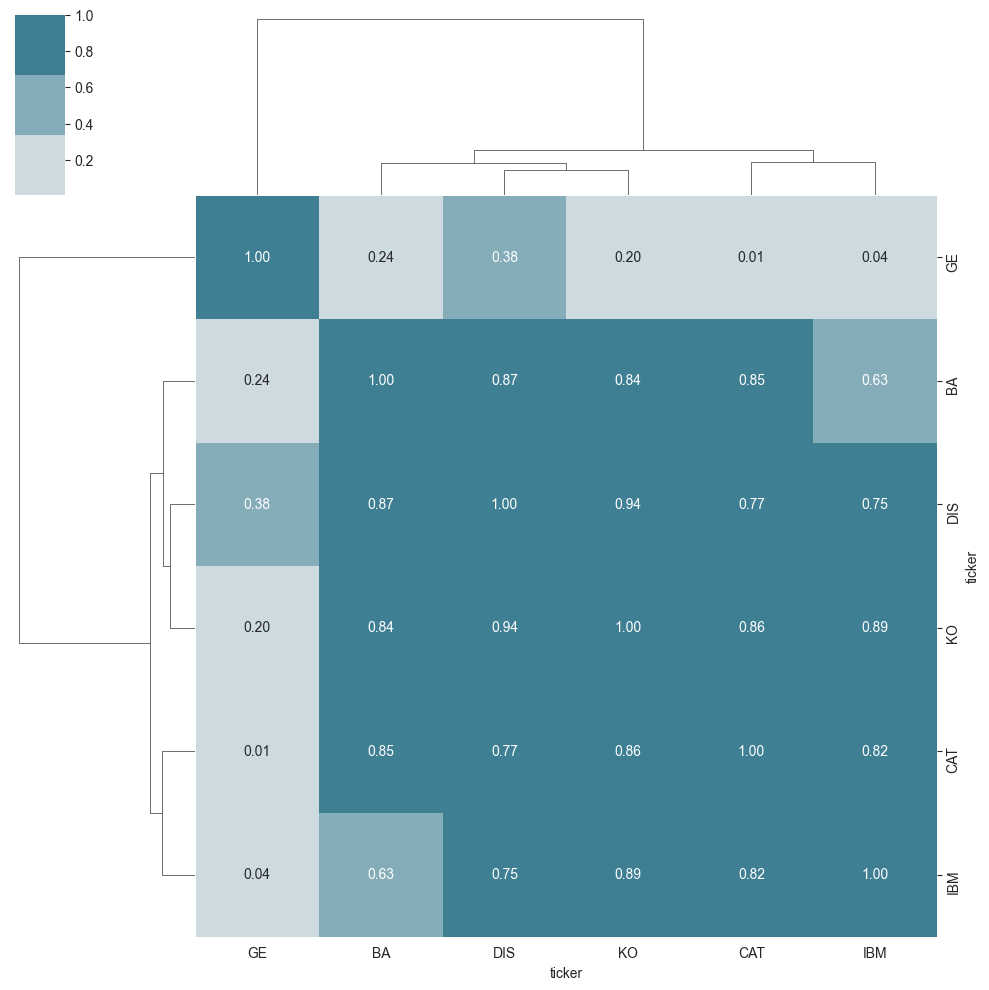

In [48]:
sns.clustermap(df.corr(),
               annot=True,
               fmt='.2f',
               cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0);

## Normalize Data

In [16]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

## Create rolling window sequences

In [125]:
data = []
for i in range(0, len(df) - seq_len):
    data.append(df[i:i + seq_len])

n_windows = len(data)

In [126]:
data[0].shape

len(data)

print(data[0])
print(data[1])
print(data[2])

ticker             BA        CAT        DIS         GE        IBM         KO
date                                                                        
2000-01-03  27.180308  14.984244  23.839401  29.005613  85.155442  17.779754
2000-01-04  27.139731  14.790123  25.235618  27.845388  82.263093  17.839810
2000-01-05  29.040120  15.347834  26.129196  27.797045  85.155442  18.035783
2000-01-06  29.121276  15.908626  25.235618  28.168317  83.687245  18.016818
2000-01-07  29.966645  16.426281  24.836699  29.258928  83.320195  19.202135
2000-01-10  29.547342  15.887058  28.626429  29.247326  86.623639  18.588931
2000-01-11  29.080698  15.637474  28.921629  29.295669  87.357738  19.221100
2000-01-12  29.121276  15.908626  26.879164  29.392354  87.724787  19.439198
2000-01-13  28.661395  16.081178  27.772743  29.730753  86.807164  19.142079
2000-01-14  29.756994  16.004146  26.775445  29.198983  87.812879  19.300121
2000-01-18  30.433289  15.488032  27.525413  28.618871  84.971917  20.545494

## Create tf.data.Dataset

In [24]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-06-08 10:24:23.866842: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-08 10:24:23.867701: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [34]:
# Show me the length of the real series
print(len(real_series))

x = 36*128 
print(x)

36
4608


In [33]:
# Show me the real_series_iter dimension for all iterations (in full range)
for i in range(3):
    print(next(real_series_iter).shape)

(128, 24, 6)
(128, 24, 6)
(128, 24, 6)


## Set up random series generator

In [35]:
def make_random_data():
    while True:
        
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

We use the Python generator to feed a `tf.data.Dataset` that continues to call the random number generator as long as necessary and produces the desired batch size.

In [36]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

2024-06-08 10:27:31.868458: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [41]:
# Show me how many random series we have
print(len(list(random_series)))

KeyboardInterrupt: 

In [37]:
next(random_series).shape

TensorShape([128, 24, 6])

# TimeGAN Components

The design of the TimeGAN components follows the author's sample code.

##  Network Parameters

In [42]:
hidden_dim = 24
num_layers = 3

## Set up logger

In [43]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

## Input place holders

In [44]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

## RNN block generator

We keep it very simple and use a very similar architecture for all four components. For a real-world application, they should be tailored to the data.

In [45]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

## Embedder & Recovery

In [46]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

## Generator & Discriminator

In [47]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

# TimeGAN Training

## Settings

In [49]:
train_steps = 10
gamma = 1

## Generic Loss Functions

In [50]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

# Phase 1: Autoencoder Training

## Architecture

In [51]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [52]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 6)]           0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            10104     
                                                                 
 Recovery (Sequential)       (None, 24, 6)             10950     
                                                                 
Total params: 21,054
Trainable params: 21,054
Non-trainable params: 0
_________________________________________________________________


In [53]:
plot_model(autoencoder,
           to_file=(results_path / 'autoencoder.png').as_posix(),
           show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Autoencoder Optimizer

In [54]:
autoencoder_optimizer = Adam()

## Autoencoder Training Step

In [55]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Autoencoder Training Loop

In [56]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

  0%|          | 0/10 [00:00<?, ?it/s]2024-06-08 10:29:51.164490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:29:51.745431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:29:53.343368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:29:54.138783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:29:55.085366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:29:55.929685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:29:56.726314: I te

## Persist model

In [57]:
# autoencoder.save(log_dir / 'autoencoder')

# Phase 2: Supervised training

## Define Optimizer

In [58]:
supervisor_optimizer = Adam()

## Train Step

In [59]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

## Training Loop

In [60]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

  0%|          | 0/10 [00:00<?, ?it/s]2024-06-08 10:30:06.923907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:30:07.334068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:30:08.177476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:30:09.028838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:30:09.845210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:30:10.661937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:30:11.717196: I te

## Persist Model

In [61]:
# supervisor.save(log_dir / 'supervisor')

# Joint Training

## Generator

### Adversarial Architecture - Supervised

In [62]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [63]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 6)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            10104     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 28,729
Trainable params: 28,729
Non-trainable params: 0
_________________________________________________________________


In [64]:
plot_model(adversarial_supervised, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Adversarial Architecture in Latent Space

In [65]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [66]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 6)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            10104     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 20,929
Trainable params: 20,929
Non-trainable params: 0
_________________________________________________________________


In [67]:
plot_model(adversarial_emb, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Mean & Variance Loss

In [68]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [69]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 6)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            10104     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Recovery (Sequential)       (None, 24, 6)             10950     
                                                                 
Total params: 28,854
Trainable params: 28,854
Non-trainable params: 0
_________________________________________________________________


In [70]:
plot_model(synthetic_data, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [71]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

## Discriminator

### Architecture: Real Data

In [72]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [73]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 6)]           0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            10104     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 20,929
Trainable params: 20,929
Non-trainable params: 0
_________________________________________________________________


In [74]:
plot_model(discriminator_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Optimizers

In [75]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

## Generator Train Step

In [76]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

## Embedding Train Step

In [77]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Discriminator Train Step

In [78]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [79]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

## Training Loop

In [80]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 10 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

2024-06-08 10:30:27.606385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:30:30.081658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:30:30.081767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:30:30.082536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:30:30.082603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:30:33.528639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:30:33.531191: I tensorflow/core/grappler/optimizers/cust

     0 | d_loss: 2.1271 | g_loss_u: 0.6433 | g_loss_s: 0.0002 | g_loss_v: 0.3158 | e_loss_t0: 0.2585


2024-06-08 10:32:14.829769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:32:15.597741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:32:15.597765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:32:15.597794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:32:18.240603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:32:18.244296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-08 10:32:18.249213: I tensorflow/core/grappler/optimizers/cust

## Persist Synthetic Data Generator

In [58]:
synthetic_data.save(log_dir / 'synthetic_data')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: time_gan/experiment_00/synthetic_data/assets


# Generate Synthetic Data

In [131]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [132]:
print(generated_data[0].shape)
print(len(generated_data))

print(128*35)
print(4480/24)

print(len(df))

(128, 24, 6)
35
4480
186.66666666666666
4586


In [133]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(4480, 24, 6)

In [62]:
np.save(log_dir / 'generated_data.npy', generated_data)

## Rescale

In [134]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(4480, 24, 6)

In [119]:
print(generated_data[0])

[[172.49753   83.79328   61.941284  20.359394 112.76657   29.393705]
 [149.85214   76.5293    59.06947   20.824842 111.09947   28.5786  ]
 [127.78002   69.26673   55.961887  21.209894 109.739685  27.750748]
 [110.10694   63.292183  53.09916   21.446924 109.01728   26.983786]
 [ 97.260475  58.846     50.678455  21.55701  108.74889   26.329052]
 [ 88.25337   55.671303  48.717495  21.588043 108.67402   25.806465]
 [ 81.96031   53.434525  47.16643   21.577766 108.6298    25.410845]
 [ 77.51049   51.863613  45.957233  21.548439 108.55164   25.123503]
 [ 74.30631   50.76132   45.022324  21.51171  108.43024   24.921663]
 [ 71.953354  49.98888   44.30205   21.473425 108.277824  24.783863]
 [ 70.1925    49.44914   43.747215  21.436474 108.11063   24.692226]
 [ 68.85174   49.073906  43.318943  21.402254 107.94204   24.632933]
 [ 67.81488   48.815224  42.98737   21.371374 107.7812    24.595798]
 [ 67.00193   48.63926   42.729733  21.343994 107.63344   24.573534]
 [ 66.356804  48.522076  42.528816

## Persist Data

In [64]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq),
                                             columns=tickers))

## Plot sample Series

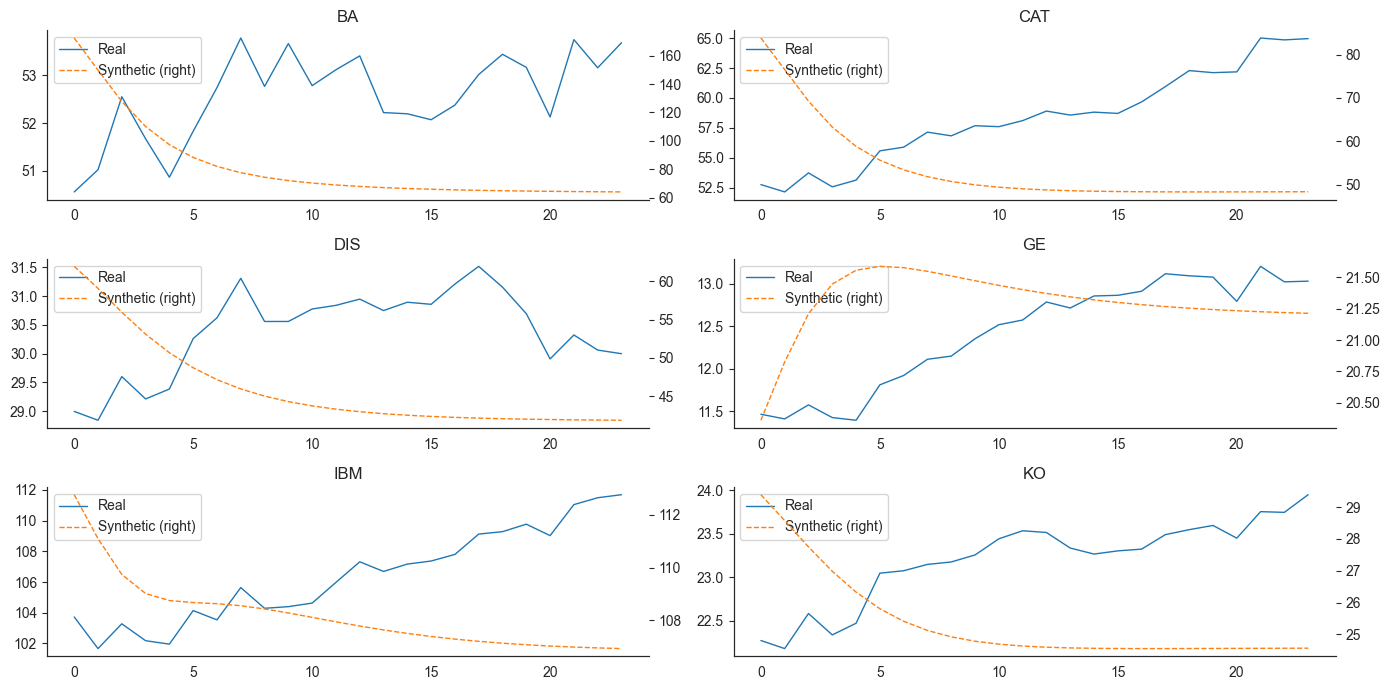

In [177]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()

In [184]:
generated_data.shape

(4480, 24, 6)

In [186]:
print(generated_data[143])

[[172.49767   83.79344   61.941307  20.359356 112.76662   29.393694]
 [149.8526    76.529854  59.06952   20.824717 111.0996    28.578543]
 [127.7809    69.26771   55.96199   21.20965  109.73986   27.750639]
 [110.10824   63.29343   53.099354  21.446564 109.01744   26.983635]
 [ 97.26219   58.84735   50.678764  21.556557 108.748924  26.32888 ]
 [ 88.2554    55.672585  48.717903  21.587545 108.6738    25.806288]
 [ 81.962555  53.43564   47.166893  21.57727  108.62926   25.410675]
 [ 77.51278   51.864525  45.957645  21.547981 108.550804  25.123337]
 [ 74.308495  50.762043  45.02261   21.51132  108.42919   24.921503]
 [ 71.95529   49.989323  44.302254  21.473122 108.27667   24.783745]
 [ 70.19407   49.449135  43.74745   21.436274 108.10945   24.6922  ]
 [ 68.85287   49.073334  43.31933   21.402159 107.94095   24.63302 ]
 [ 67.81559   48.814095  42.987904  21.371363 107.780266  24.59599 ]
 [ 67.0023    48.63765   42.730373  21.344048 107.632706  24.573797]
 [ 66.35689   48.520123  42.52948 

143


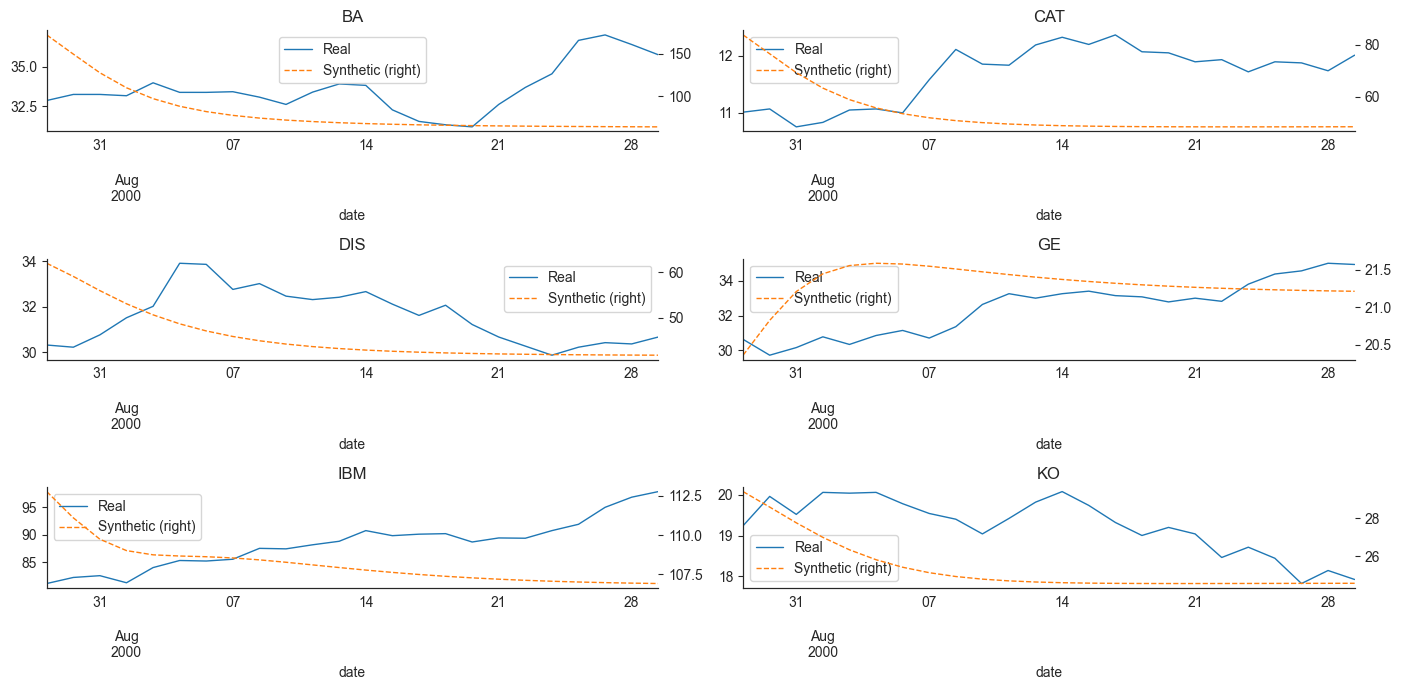

In [179]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))

obs = np.random.randint(len(df))
print(obs)


for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': df.iloc[obs: obs + seq_len].iloc[:, j],
                   'Synthetic': generated_data[obs][:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()

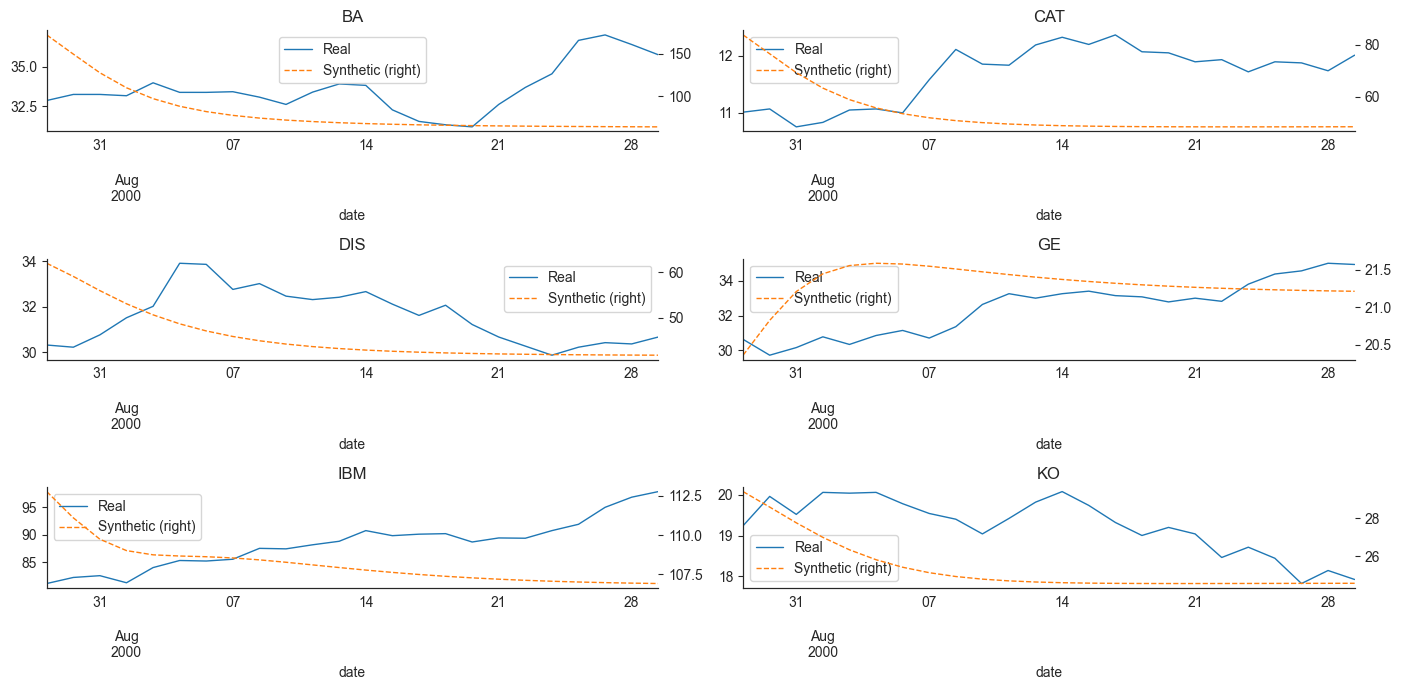

In [183]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
# synthetic = generated_data[np.random.randint(n_windows)]

idx = 143
real = df.iloc[idx: idx + seq_len]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j],
                   'Synthetic': generated_data[idx][:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()